# Does alcohol Consumption Make our Sleep Less Efficient?

In [387]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.core.frame import DataFrame
from IPython.display import display
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

 ### 1. ensure data types are appropriate and there is no missing data

In [388]:
df = pd.read_csv('/Users/amit/Documents/Code/python/life-expectancy/life-expectancy.csv', dtype={'Country':'category', 'Status':'category'})

n_rows, n_columns = df.shape 
total_data = n_rows * n_columns
print(f'total rows: {n_rows} \ntotal columns: {n_columns} \ntotal data: {total_data}')

df.head()

total rows: 2938 
total columns: 22 
total data: 64636


,Country,Year,Status,Lifeexpectancy,AdultMortality,infantdeaths,Alcohol,percentageexpenditure,HepatitisB,Measles,...,Polio,Totalexpenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness1-19years,thinness5-9years,Incomecompositionofresources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [389]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Country                       2938 non-null   category
 1   Year                          2938 non-null   int64   
 2   Status                        2938 non-null   category
 3   Lifeexpectancy                2928 non-null   float64 
 4   AdultMortality                2928 non-null   float64 
 5   infantdeaths                  2938 non-null   int64   
 6   Alcohol                       2744 non-null   float64 
 7   percentageexpenditure         2938 non-null   float64 
 8   HepatitisB                    2385 non-null   float64 
 9   Measles                       2938 non-null   int64   
 10  BMI                           2904 non-null   float64 
 11  under-fivedeaths              2938 non-null   int64   
 12  Polio                         2919 non-null   fl

- Country's Dtype was originally object, it has been changed to categorical data
- Status's Dtype was originally object, it has been changed to categorical data


In [390]:
print('number of nulls is: ', df.isnull().sum().sum())
df.isnull().sum()

number of nulls is:  2563


Country                           0
Year                              0
Status                            0
Lifeexpectancy                   10
AdultMortality                   10
infantdeaths                      0
Alcohol                         194
percentageexpenditure             0
HepatitisB                      553
Measles                           0
BMI                              34
under-fivedeaths                  0
Polio                            19
Totalexpenditure                226
Diphtheria                       19
HIV/AIDS                          0
GDP                             448
Population                      652
thinness1-19years                34
thinness5-9years                 34
Incomecompositionofresources    167
Schooling                       163
dtype: int64

the percentage of missing data is:
$$
\frac{2563}{64636} \cdot 100 \approx 4\%
$$
which is less then 5%, so __there is no need for imputation__, this percent won't effect the overall data.

In [391]:
df.dropna(inplace=True)

### 2. statistical summaries

In [392]:
def summary_stats(dataframe: DataFrame, numeric_only=True, style=True):
    if numeric_only:
        numeric_cols = dataframe.select_dtypes(include=['number']).columns
        summary = dataframe[numeric_cols].describe().T
        summary["variance"] = dataframe[numeric_cols].var()
        if style:
            summary = summary.style.format("{:.2f}").background_gradient(cmap="Oranges", axis=1, subset=summary.columns.drop("count"))
    else:
        numeric_cols = dataframe.select_dtypes(include=['number']).columns
        summary = dataframe.describe(exclude="number")
    return summary



numeric_cols_summary = summary_stats(df, style=True)
category_cols_summary = summary_stats(df, numeric_only=False)

display(numeric_cols_summary)
display(category_cols_summary)

,count,mean,std,min,25%,50%,75%,max,variance
Year,1649.00,2007.84,4.09,2000.00,2005.00,2008.00,2011.00,2015.00,16.71
Lifeexpectancy,1649.00,69.30,8.80,44.00,64.40,71.70,75.00,89.00,77.38
AdultMortality,1649.00,168.22,125.31,1.00,77.00,148.00,227.00,723.00,15702.70
infantdeaths,1649.00,32.55,120.85,0.00,1.00,3.00,22.00,1600.00,14604.04
Alcohol,1649.00,4.53,4.03,0.01,0.81,3.79,7.34,17.87,16.23
percentageexpenditure,1649.00,698.97,1759.23,0.00,37.44,145.10,509.39,18961.35,3094887.86
HepatitisB,1649.00,79.22,25.60,2.00,74.00,89.00,96.00,99.00,655.60
Measles,1649.00,2224.49,10085.80,0.00,0.00,15.00,373.00,131441.00,101723402.36
BMI,1649.00,38.13,19.75,2.00,19.50,43.70,55.80,77.10,390.23
under-fivedeaths,1649.00,44.22,162.90,0.00,1.00,4.00,29.00,2100.00,26535.76


,Country,Status
count,1649,1649
unique,133,2
top,Afghanistan,Developing
freq,16,1407


All of the statistics that have a very high variance, probably have a lot of outliers that have BIG impact on our data, we will remove them.<br/><br/><sub><sup>__but that will be handled in section 4__</sup></sub>

### 3. Outcome and Input Variables
__Outcome variable__: Life expectancy

__Input Variables__:
1. Alcohol
2. BMI
3. Schooling
4. Income composition of resources

### 4. Find and remove outliers

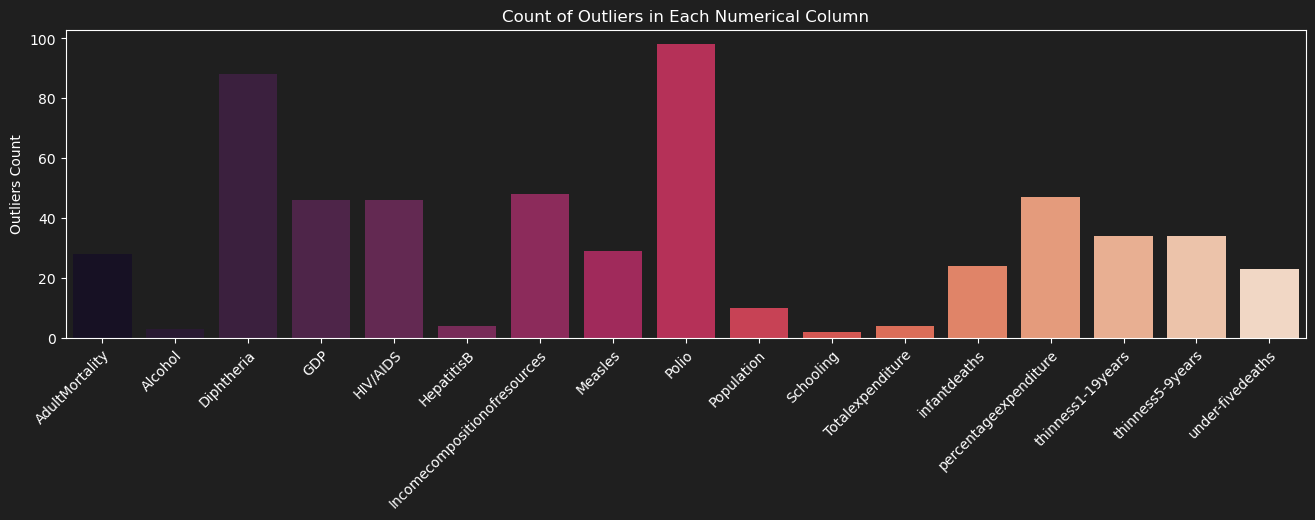

In [393]:
def find_outliers(column):
    mean = df[column].mean()
    std_dev = df[column].std()
    lower_bound = mean - 3 * std_dev
    upper_bound = mean + 3 * std_dev
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)].copy()
    outliers['Column'] = column
    return outliers

numeric_df_columns = df.select_dtypes(include=['number']).columns
all_outliers = pd.concat([find_outliers(col) for col in numeric_df_columns])
outliers_count = all_outliers.groupby('Column').size().reset_index(name='OutliersCount')

with plt.style.context('dark_background'):
    plt.rcParams.update({
        'figure.facecolor': '#1f1f1f',
        'axes.facecolor': '#1f1f1f',
        'axes.edgecolor': 'white',
    })

    plt.figure(figsize=(16, 4))
    bar_plot = sns.barplot(x='Column', y='OutliersCount', data=outliers_count, palette='rocket')
    plt.title('Count of Outliers in Each Numerical Column')
    plt.xlabel('')
    plt.ylabel('Outliers Count')
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor') 


    plt.show()

In [394]:
def remove_outliers_std(df, column):
    mean = df[column].mean()
    std_dev = df[column].std()
    lower_bound = mean - 3 * std_dev
    upper_bound = mean + 3 * std_dev
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

numeric_df = df.select_dtypes(include=['number'])
numeric_df_without_outliers = numeric_df.copy()
for col in numeric_df_without_outliers.columns:
    numeric_df_without_outliers = remove_outliers_std(numeric_df_without_outliers, col)

print(f'Rows before removing outliers: {numeric_df.shape[0]}')
print(f'Rows after removing outliers: {numeric_df_without_outliers.shape[0]}')

Rows before removing outliers: 1649
Rows after removing outliers: 1162


So we got to the point... does schooling really make our life longer?
### 5. test the hypothesis

$$H_0 = \text{Greater education extends life expectancy}$$
$$H_1 = \text{Greater education does not extend life expectancy}$$

We will choose a significance value of 0.95; meaning a p-value of 0.05
<br/>(but we will also show results for p-values: 0.1, 0.005)

#### first test - correlation

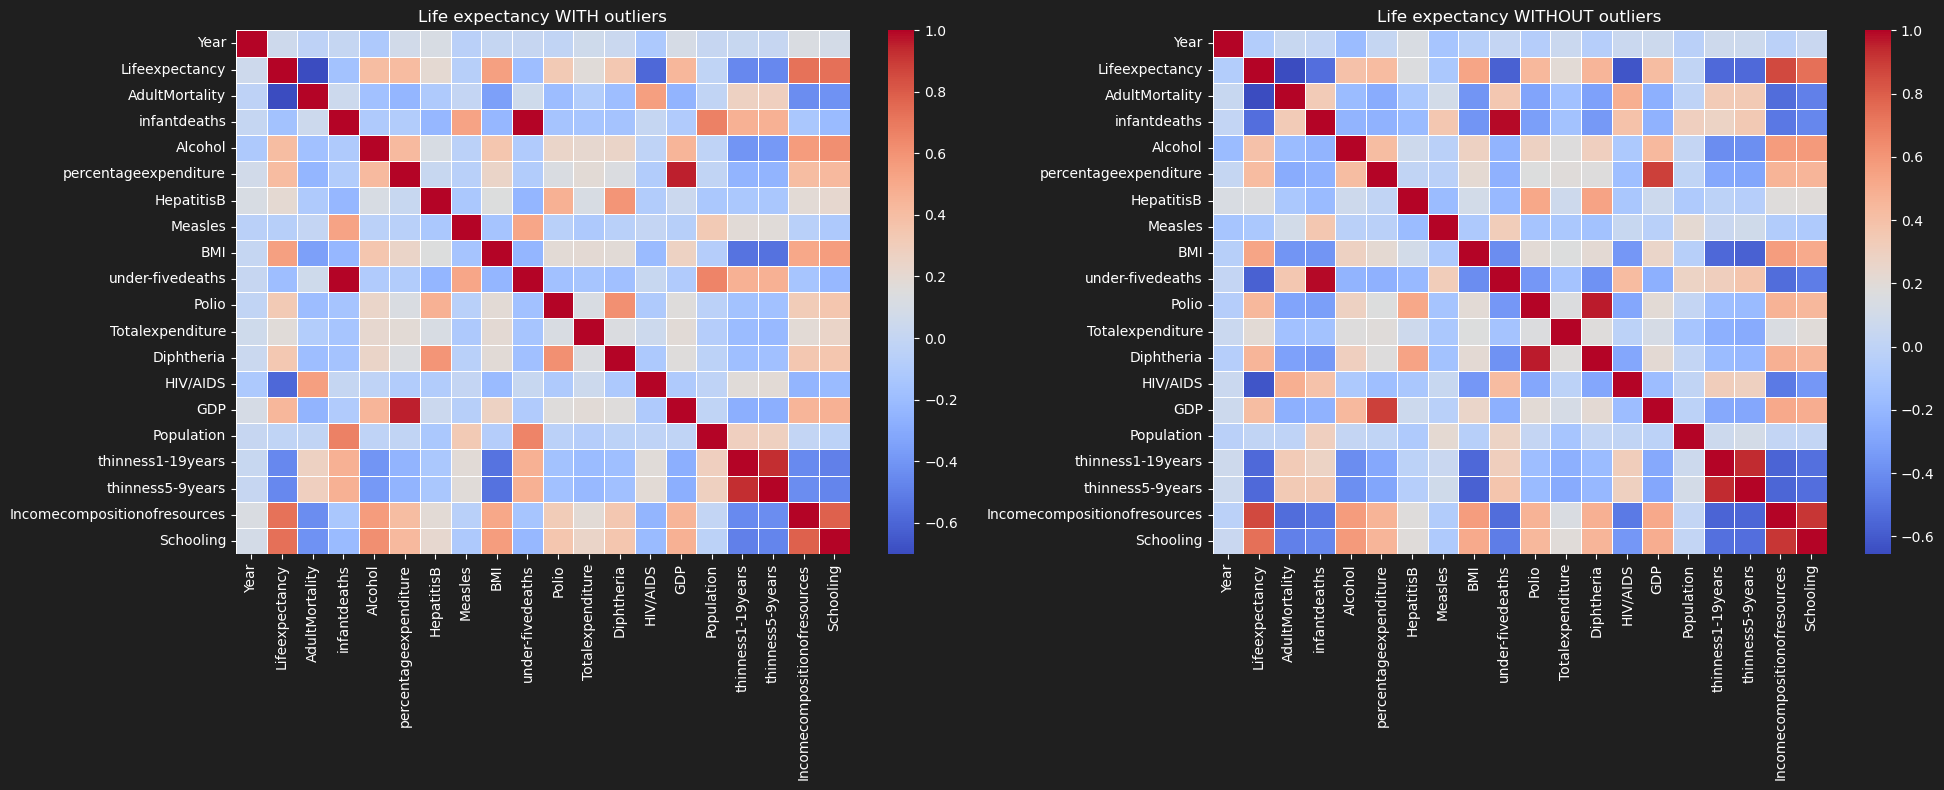

In [395]:
corr_matrix_with_outliers = numeric_df.corr()
corr_matrix_without_outliers = numeric_df_without_outliers.corr()
with plt.style.context('dark_background'):
    plt.rcParams.update({
        'figure.facecolor': '#1f1f1f',
        'axes.facecolor': '#1f1f1f',
    })

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    sns.heatmap(corr_matrix_with_outliers, cmap="coolwarm", linewidths=0.5, fmt=".2f", ax=axes[0])
    axes[0].set_title('Life expectancy WITH outliers')

    sns.heatmap(corr_matrix_without_outliers, cmap="coolwarm", linewidths=0.5, fmt=".2f", ax=axes[1])
    axes[1].set_title('Life expectancy WITHOUT outliers')

    plt.tight_layout()
    plt.show()

we can see that there __is__ a correlation between Life expectancy and Schooling, but this does not answer our hypothesis, but it does give us a glimpse of knowledge about the relation between our candidates.
<br/>
<br/>
in order to answer our hypothesis we need to understand the distribution of our data to know which tests to take (parametric vs non parametric).

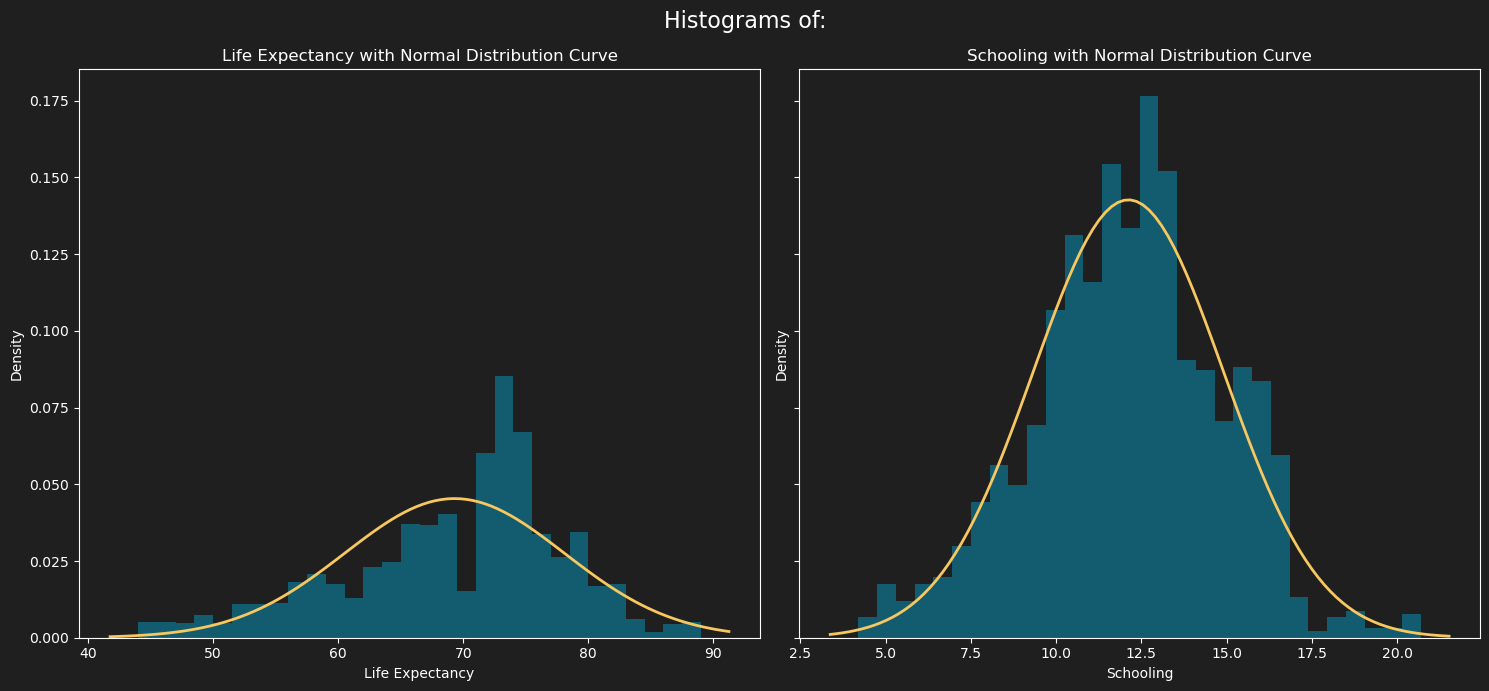

In [396]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
with plt.style.context('dark_background'):
    fig.patch.set_facecolor('#1f1f1f')
    for ax in axes:
        ax.set_facecolor('#1f1f1f')
        ax.tick_params(colors='white', which='both')
        ax.spines['top'].set_color('white')
        ax.spines['bottom'].set_color('white')
        ax.spines['left'].set_color('white')
        ax.spines['right'].set_color('white')
    
    # Plot Life Expectancy distribution
    axes[0].hist(df['Lifeexpectancy'], bins=30, density=True, alpha=0.6, color='#0b84a5')

    xmin, xmax = axes[0].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, df['Lifeexpectancy'].mean(), df['Lifeexpectancy'].std())
    axes[0].plot(x, p, linewidth=2, color='#f6c85f')

    axes[0].set_title('Life Expectancy with Normal Distribution Curve', color='white')
    axes[0].set_xlabel('Life Expectancy', color='white')
    axes[0].set_ylabel('Density', color='white')

    # Plot Schooling distribution
    axes[1].hist(df['Schooling'], bins=30, density=True, alpha=0.6, color='#0b84a5')

    xmin, xmax = axes[1].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, df['Schooling'].mean(), df['Schooling'].std())
    axes[1].plot(x, p, linewidth=2, color='#f6c85f')

    axes[1].set_title('Schooling with Normal Distribution Curve', color='white')
    axes[1].set_xlabel('Schooling', color='white')
    axes[1].set_ylabel('Density', color='white')

plt.suptitle('Histograms of:', fontsize=16, color='white')
plt.tight_layout()
plt.show()

In these histograms, we can definitely see that Life expectancy is not normal because it is not centred against the middle,<br/>
but Schooling really does fit the normal distribution.<br/><br/>
so let's test it!

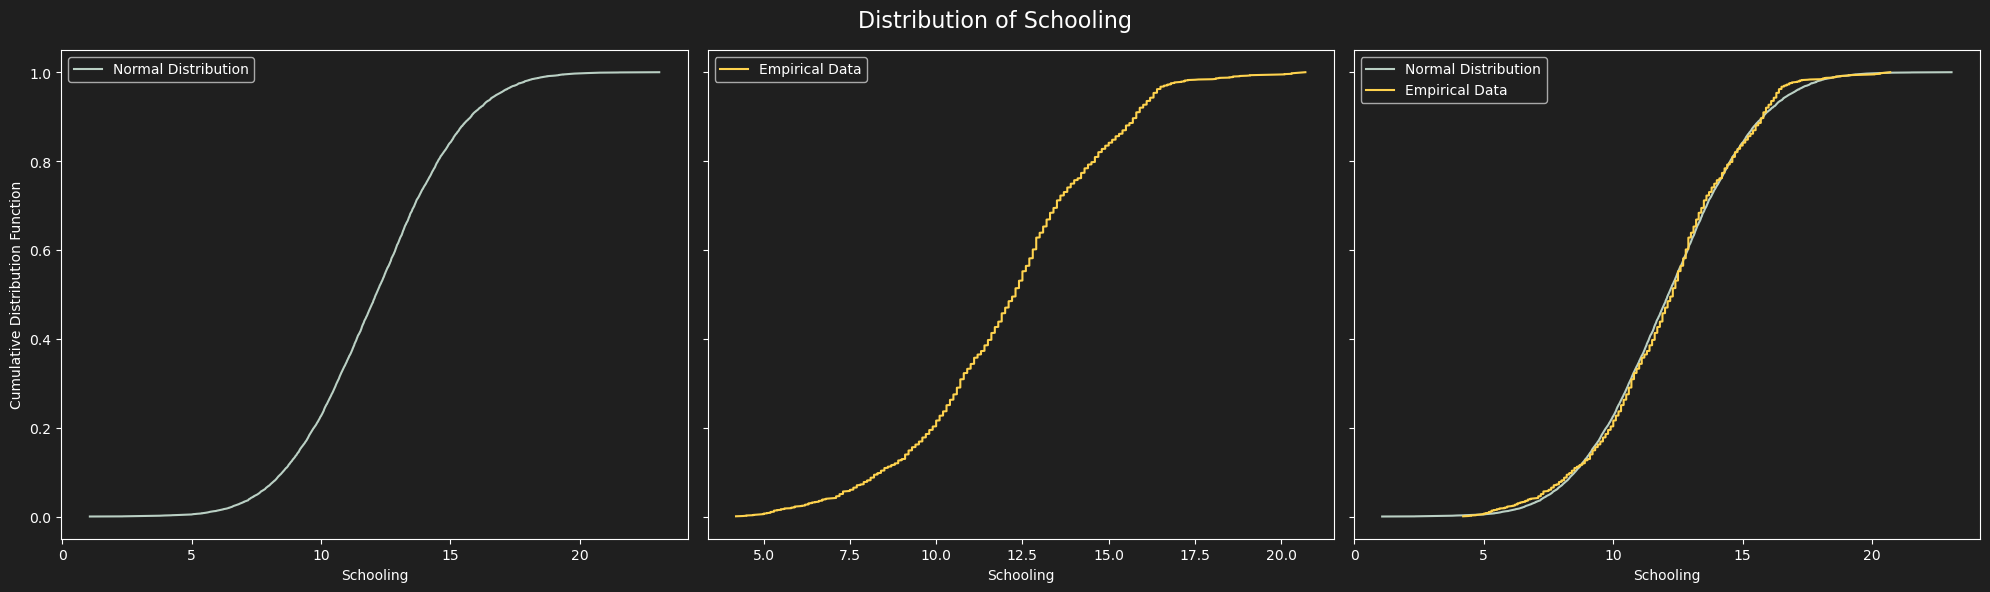

NormaltestResult(statistic=4.697317581548514, pvalue=0.09549715803116184)
KstestResult(statistic=0.030841050589887287, pvalue=0.08503477921702862, statistic_location=12.3, statistic_sign=-1)


In [397]:
# Generate samples for the normal distribution
samples = np.random.normal(np.mean(df["Schooling"]), np.std(df["Schooling"]), size=10000)
x_theor, y_theor = ecdf(samples)

x_emp, y_emp = ecdf(df["Schooling"])

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
with plt.style.context('dark_background'):
    fig.patch.set_facecolor('#1f1f1f')
    for ax in axes:
        ax.set_facecolor('#1f1f1f')
        ax.tick_params(colors='white', which='both')
        ax.spines['top'].set_color('white')
        ax.spines['bottom'].set_color('white')
        ax.spines['left'].set_color('white')
        ax.spines['right'].set_color('white')
    
    # Plot theoretical distribution
    axes[0].plot(x_theor, y_theor, label='Normal Distribution', color='#bad0c4')
    axes[0].set_xlabel("Schooling", color='white')
    axes[0].set_ylabel("Cumulative Distribution Function", color='white')
    axes[0].legend(facecolor='#1f1f1f')

    # Plot empirical data
    axes[1].plot(x_emp, y_emp, label='Empirical Data', color='#ffd34e')
    axes[1].set_xlabel("Schooling", color='white')
    axes[1].legend(facecolor='#1f1f1f')

    axes[2].plot(x_theor, y_theor, label='Normal Distribution', color='#bad0c4')
    axes[2].plot(x_emp, y_emp, label='Empirical Data', color='#ffd34e')
    axes[2].set_xlabel("Schooling", color='white')
    axes[2].legend(facecolor='#1f1f1f')

    fig.suptitle('Distribution of Schooling' , fontsize=16)

plt.tight_layout()
plt.show()

print(stats.normaltest(df["Schooling"]))
print(stats.kstest(df["Schooling"], 'norm', args=(df["Schooling"].mean(), df["Schooling"].std()))
)

in the stats.Normaltest we are peforming a 2-sided chi squared probability with the null hypothesis that this sample data is normally distributed.<br/>
if the p-value result is less than our significance level, we will reject the null hypothesis, otherwise, we will accept it.
<br/><br/>
our p-value result is 0.09549715803116184 which is > 0.05 thus, we will accept our null hypothesis:<br/>
- __Schooling is normally distributed__

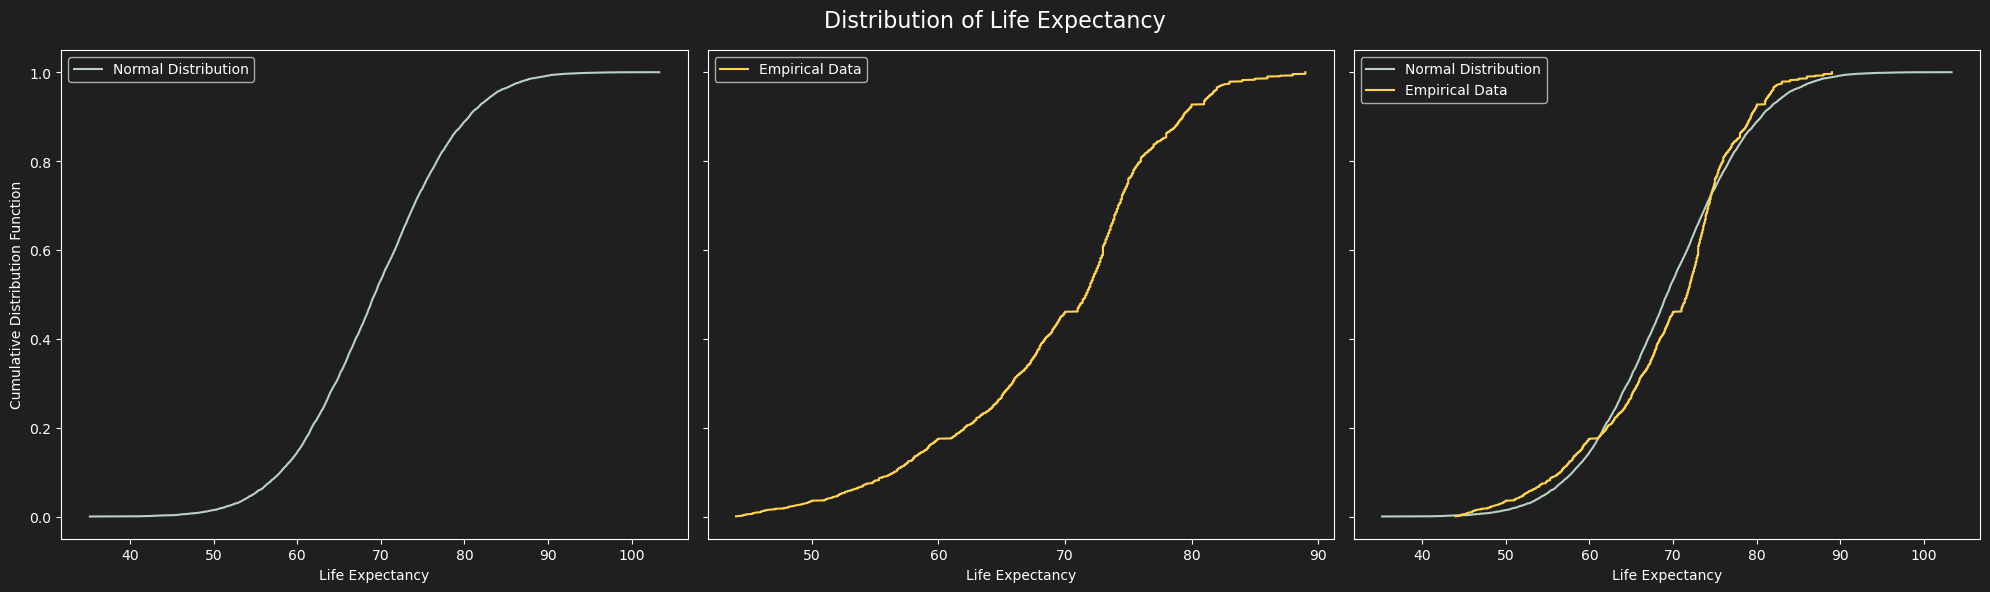

NormaltestResult(statistic=93.1464769584523, pvalue=5.9360769772633565e-21)
KstestResult(statistic=0.11563097260702732, pvalue=1.1536138937266938e-19, statistic_location=71.0, statistic_sign=-1)


In [398]:
def ecdf(data):
    length = len(data)
    x = np.sort(data)
    y = np.arange(1, length+1) / length
    return x, y

# Generate samples for the normal distribution
samples = np.random.normal(np.mean(df["Lifeexpectancy"]), np.std(df["Lifeexpectancy"]), size=10000)
x_theor, y_theor = ecdf(samples)

x_emp, y_emp = ecdf(df["Lifeexpectancy"])

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
with plt.style.context('dark_background'):
    fig.patch.set_facecolor('#1f1f1f')
    for ax in axes:
        ax.set_facecolor('#1f1f1f')
        ax.tick_params(colors='white', which='both')
        ax.spines['top'].set_color('white')
        ax.spines['bottom'].set_color('white')
        ax.spines['left'].set_color('white')
        ax.spines['right'].set_color('white')
    
    # Plot theoretical distribution
    axes[0].plot(x_theor, y_theor, label='Normal Distribution', color='#bad0c4')
    axes[0].set_xlabel("Life Expectancy", color='white')
    axes[0].set_ylabel("Cumulative Distribution Function", color='white')
    axes[0].legend(facecolor='#1f1f1f')

    # Plot empirical data
    axes[1].plot(x_emp, y_emp, label='Empirical Data', color='#ffd34e')
    axes[1].set_xlabel("Life Expectancy", color='white')
    axes[1].legend(facecolor='#1f1f1f')

    axes[2].plot(x_theor, y_theor, label='Normal Distribution', color='#bad0c4')
    axes[2].plot(x_emp, y_emp, label='Empirical Data', color='#ffd34e')
    axes[2].set_xlabel("Life Expectancy", color='white')
    axes[2].legend(facecolor='#1f1f1f')
    
    fig.suptitle('Distribution of Life Expectancy' , fontsize=16)

plt.tight_layout()
plt.show()

print(stats.normaltest(df["Lifeexpectancy"]))
print(stats.kstest(df["Lifeexpectancy"], 'norm', args=(df["Lifeexpectancy"].mean(), df["Lifeexpectancy"].std())))

our p-value result is 0.5.9360769772633565e-21 which is << 0.05 thus, we will reject our null hypothesis:<br/>
- __Life expectancy is not normally distributed__

because we are trying to find a correlation between normal-distribution and non-normal-distribution datasets, we can't use parametric test.
<br/>
so in order to test the hypothesis, we will use few non-parametric tests:

#### Pearson's correlation 

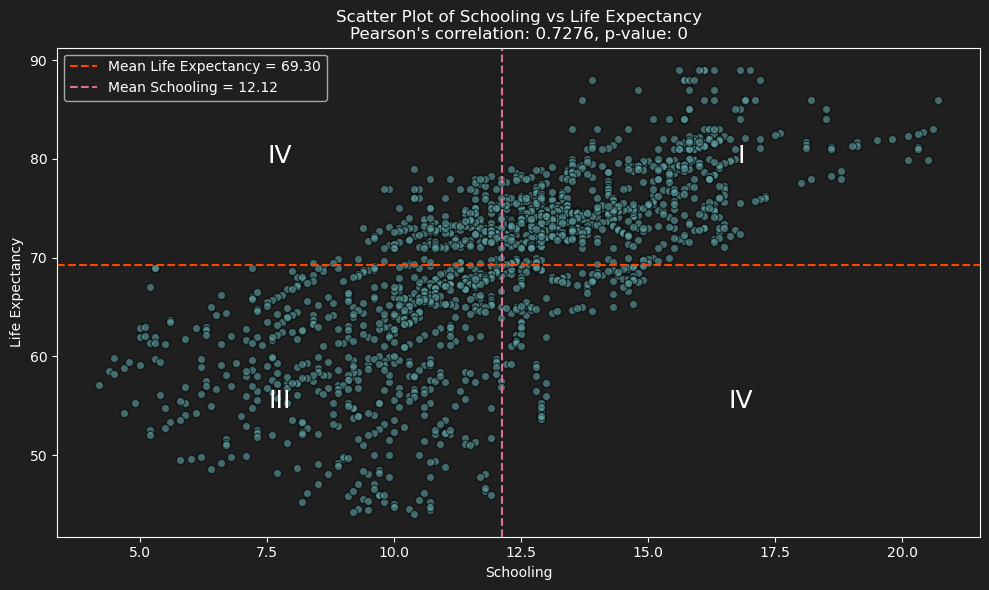

In [399]:
corr, p_value = stats.pearsonr(df['Schooling'], df['Lifeexpectancy'])

with plt.style.context('dark_background'):
    plt.rcParams.update({
        'figure.facecolor': '#1f1f1f',
        'axes.facecolor': '#1f1f1f',
    })

    plt.figure(figsize=(10, 6))
    plt.scatter(df['Schooling'], df['Lifeexpectancy'], alpha=0.6, color='cadetblue', edgecolor='k')

    # Add mean lines
    mean_schooling = df['Schooling'].mean()
    mean_lifeexpectancy = df['Lifeexpectancy'].mean()

    plt.axhline(mean_lifeexpectancy, color='orangered', linestyle='--', label=f'Mean Life Expectancy = {mean_lifeexpectancy:.2f}')
    plt.axvline(mean_schooling, color='palevioletred', linestyle='--', label=f'Mean Schooling = {mean_schooling:.2f}')

    plt.xlabel('Schooling')
    plt.ylabel('Life Expectancy')
    plt.title(f'Scatter Plot of Schooling vs Life Expectancy\nPearson\'s correlation: {corr:.4f}, p-value: {p_value:.0f}')
    plt.legend()

    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()

    # Midpoints
    x_mid_left = (xmin + mean_schooling) / 2
    x_mid_right = (xmax + mean_schooling) / 2
    y_mid_bottom = (ymin + mean_lifeexpectancy) / 2
    y_mid_top = (ymax + mean_lifeexpectancy) / 2

    plt.text(x_mid_left, y_mid_top, 'IV', fontsize=18, ha='center', va='center', color='white')
    plt.text(x_mid_right, y_mid_top, 'I', fontsize=18, ha='center', va='center', color='white')
    plt.text(x_mid_left, y_mid_bottom, 'III', fontsize=18, ha='center', va='center', color='white')
    plt.text(x_mid_right, y_mid_bottom, 'IV', fontsize=18, ha='center', va='center', color='white')

plt.tight_layout()
plt.show()

Pearson's correlation coefficient is a value between -1, to 1 that indicates the correlation/dependency between two variables, where:
- 1 means a perfect positive relation
- 0 means no relation
- -1 means a perfect negative relation

<br/>
we can see that most of our data is in quarters I & III, which means that pearson's correlation coefficient is going to be positive (of course we already calculated it...)
<br/>
our coefficient is 0.7276 which indicates high positive correlation, meaning:

$$ \text{higher schooling} \longrightarrow \text{higher life expectancy} $$

#### Spearman's correlation 

In [400]:
corr, p_value = stats.spearmanr(df['Schooling'], df['Lifeexpectancy'])
print(f"Spearman's correlation: {corr}, p-value: {p_value}")

Spearman's correlation: 0.7747691193054028, p-value: 0.0


#### Linear regression
According to Pearson's coefficient there is a correlation between Schooling and Life expectancy, so in order to find a prediction formula, we will use linear regression.

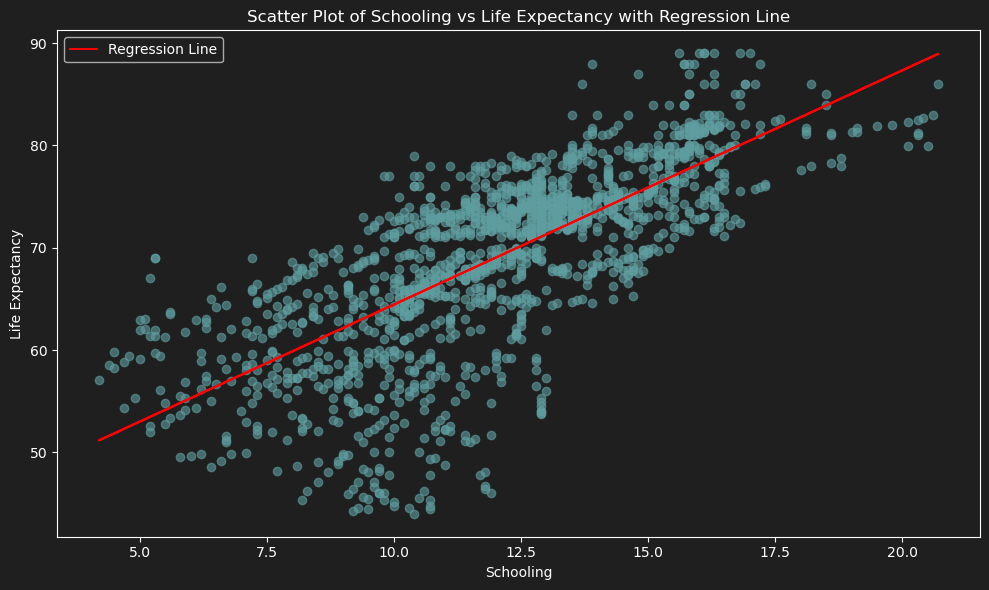

In [402]:
slope, intercept = np.polyfit(df['Schooling'], df['Lifeexpectancy'], 1)

with plt.style.context('dark_background'):
    plt.rcParams.update({
        'figure.facecolor': '#1f1f1f',
        'axes.facecolor': '#1f1f1f',
    })

    plt.figure(figsize=(10, 6))
    plt.scatter(df['Schooling'], df['Lifeexpectancy'], alpha=0.6, color='cadetblue')
    plt.plot(df['Schooling'], slope * df['Schooling'] + intercept, color='r', label='Regression Line') #min squared

    plt.xlabel('Schooling')
    plt.ylabel('Life Expectancy')
    plt.title('Scatter Plot of Schooling vs Life Expectancy with Regression Line')
    plt.legend()

plt.tight_layout()
plt.show()

The data scatter does seem to follow a linear regression, so let's test it.

In [445]:
import warnings
from IPython.display import Markdown
warnings.filterwarnings('ignore', category=UserWarning, message='X does not have valid feature names')


model = LinearRegression()

model.fit(df[['Schooling']], df['Lifeexpectancy'])

print(f'Intercept: {model.intercept_}')
print(f'Coefficients: {model.coef_}\n')

modelIntercept = model.intercept_
modelCoef = model.coef_[0]

markdown_text = f"""
$$ \\text{{Model equation: Lifeexpectancy}} = {modelIntercept:.2f} + {modelCoef:.2f} \\times \\text{{Schooling}} $$
"""
Markdown(markdown_text)


Intercept: 41.550341745363205
Coefficients: [2.28978652]




$$ \text{Model equation: Lifeexpectancy} = 41.55 + 2.29 \times \text{Schooling} $$


In [452]:
def predict_life_expectancy(schooling):
    return model.predict([[schooling]])

print(f'Predicted life expectancy for schooling of 15 years (highschool + first degree): {predict_life_expectancy(15)[0]:.2f}')
print(f'Predicted life expectancy for schooling of 17 years (highschool + first degree + second degree): {predict_life_expectancy(18)[0]:.2f}')
print('\nguess it is a good thing that we are here...')

Predicted life expectancy for schooling of 15 years (highschool + first degree): 75.90
Predicted life expectancy for schooling of 17 years (highschool + first degree + second degree): 82.77

guess it is a good thing that we are here...
